In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("fbref_data.csv")

# SEASON FORMATTING
def format_season(s):
    return f"20{str(s)[:2]}-20{str(s)[2:]}"
df['season_id'] = df['season'].apply(format_season)

# FEATURE SELECTION (UPDATED: Crosses removed, Att Pen Touches added)
features = [
    'Poss',                     # Possession %
    'xG',                       # Expected Goals (Offensive Quality)
    'xGA',                      # Expected Goals Against (Defensive Quality)
    'Pass_Pass Types_CK',       # Corner Kicks (Pressure)
    'Def_Tackles_Att 3rd',      # High Press Intensity
    'Def_Clr_',                 # Clearances (Deep Block Indicator)
    'Poss_Carries_PrgC',        # Progressive Carries (Transition/Dribbling)
    'Poss_Touches_Att Pen'      # Touches in Penalty Area (Box Presence) <--- NEW
]

# Check if columns exist
available_features = [f for f in features if f in df.columns]
print(f"Features used for clustering: {len(available_features)}")
print(available_features)

# DATA AGGREGATION (Home & Away Profiles)
home_df = df[df['venue'] == 'Home'].copy()
away_df = df[df['venue'] == 'Away'].copy()

# Group by Season + Team
home_profiles = home_df.groupby(['season_id', 'team'])[available_features].mean().dropna()
away_profiles = away_df.groupby(['season_id', 'team'])[available_features].mean().dropna()

# K-MEANS CLUSTERING (K=6)
scaler = StandardScaler()

# -- Fit Home Model --
home_scaled = scaler.fit_transform(home_profiles)
kmeans_home = KMeans(n_clusters=6, random_state=42, n_init=10)
home_profiles['cluster'] = kmeans_home.fit_predict(home_scaled)

# -- Fit Away Model --
away_scaled = scaler.fit_transform(away_profiles)
kmeans_away = KMeans(n_clusters=6, random_state=42, n_init=10)
away_profiles['cluster'] = kmeans_away.fit_predict(away_scaled)

print("Clustering complete. 6 tactical profiles identified.")

# AUTOMATIC LABELING LOGIC (UPDATED with Box Siege)
def auto_label_clusters(profile_df):
    labels = {}
    stats = profile_df.groupby('cluster')[available_features].mean()

    # --- STEP 1: IDENTIFY ELITE DOMINANT ---
    # Find the cluster with the highest Expected Goals (xG)
    elite_id = stats['xG'].idxmax()
    labels[elite_id] = "Elite Dominant"

    # --- STEP 2: IDENTIFY DEEP BLOCK ---
    if 'Def_Clr_' in stats.columns:
        remaining = stats.drop(index=[elite_id], errors='ignore')
        if not remaining.empty:
            bus_id = remaining['Def_Clr_'].idxmax()
            if bus_id not in labels:
                labels[bus_id] = "Deep Block"

    # --- STEP 3: IDENTIFY HIGH PRESSING ---
    if 'Def_Tackles_Att 3rd' in stats.columns:
        remaining = stats.drop(index=list(labels.keys()), errors='ignore')
        if not remaining.empty:
            press_id = remaining['Def_Tackles_Att 3rd'].idxmax()
            if press_id not in labels:
                labels[press_id] = "High Pressing"

    # --- STEP 4: IDENTIFY BOX SIEGE (High Pen Area Touches)
    # Teams that get into the box a lot but are not Elite
    if 'Poss_Touches_Att Pen' in stats.columns:
        remaining = stats.drop(index=list(labels.keys()), errors='ignore')
        if not remaining.empty:
            siege_id = remaining['Poss_Touches_Att Pen'].idxmax()
            labels[siege_id] = "Box Siege"

    # --- STEP 5: IDENTIFY TRANSITION/CARRIES ---
    if 'Poss_Carries_PrgC' in stats.columns:
        remaining = stats.drop(index=list(labels.keys()), errors='ignore')
        if not remaining.empty:
            carrier_id = remaining['Poss_Carries_PrgC'].idxmax()
            labels[carrier_id] = "Transition/Carries"

    # --- STEP 6: LABEL REMAINDER (Counter vs. Balanced) ---
    for c in stats.index:
        if c not in labels:
            if stats.loc[c, 'Poss'] < 45:
                labels[c] = "Counter Attack"
            else:
                labels[c] = "Balanced"
    return labels

home_labels = auto_label_clusters(home_profiles)
away_labels = auto_label_clusters(away_profiles)

print("\nIDENTIFIED HOME STYLES:", home_labels)

# MERGE LABELS BACK TO MAIN DATASET
df_final = df.copy()

# Merge Home Styles
df_final = pd.merge(df_final, home_profiles[['cluster']], on=['season_id', 'team'], how='left')
df_final['Home_Style'] = df_final['cluster'].map(home_labels)
df_final.drop(columns=['cluster'], inplace=True)

# Merge Away Styles
away_lookup = away_profiles[['cluster']].reset_index()
away_lookup.columns = ['season_id', 'opponent', 'cluster_away']

df_final = pd.merge(df_final, away_lookup, on=['season_id', 'opponent'], how='left')
df_final['Away_Style'] = df_final['cluster_away'].map(away_labels)
df_final.drop(columns=['cluster_away'], inplace=True)

# Save Final Dataset
df_final = df_final.dropna(subset=['Home_Style', 'Away_Style'])
output_filename = "premier_league_styles.csv"
df_final.to_csv(output_filename, index=False)

print(f"\nSUCCESS: File saved as '{output_filename}'")
print("Sample Matches with Styles:")
print(df_final[['date', 'team', 'opponent', 'Home_Style', 'Away_Style']].sample(5))

Features used for clustering: 8
['Poss', 'xG', 'xGA', 'Pass_Pass Types_CK', 'Def_Tackles_Att 3rd', 'Def_Clr_', 'Poss_Carries_PrgC', 'Poss_Touches_Att Pen']
Clustering complete. 6 tactical profiles identified.

IDENTIFIED HOME STYLES: {np.int32(2): 'Elite Dominant', np.int32(4): 'Deep Block', np.int32(1): 'High Pressing', np.int32(5): 'Box Siege', np.int32(0): 'Transition/Carries', 3: 'Balanced'}

SUCCESS: File saved as 'premier_league_styles.csv'
Sample Matches with Styles:
            date            team        opponent          Home_Style  \
1249  2021-05-09  Manchester Utd     Aston Villa  Transition/Carries   
2281  2022-08-13         Arsenal  Leicester City      Elite Dominant   
2983  2023-01-21        West Ham         Everton            Balanced   
2349  2023-04-22     Aston Villa       Brentford            Balanced   
130   2019-12-16        Brighton  Crystal Palace       High Pressing   

              Away_Style  
1249  Transition/Carries  
2281          Deep Block  
2983   

In [22]:
import pandas as pd

# Merge Styles back to Original Data (if not already done)
# We need this step because some stats (like Shots) are in the main 'home_df' but not in 'home_profiles'
home_profiles['Style'] = home_profiles['cluster'].map(home_labels).fillna("Others")

df_analysis = pd.merge(
    home_df,
    home_profiles[['Style']],
    left_on=['season_id', 'team'],
    right_index=True,
    how='inner'
)

print(f"Analysis Table Ready. Rows: {len(df_analysis)}")

# Define Target Group
target_style = "Box Siege"

# Fallback check if 'Box Siege' does not exist in the current clustering run
if target_style not in df_analysis['Style'].unique():
    print(f"Warning: '{target_style}' label not found. Defaulting to 'Elite Dominant'.")
    if "Elite Dominant" in df_analysis['Style'].unique():
        target_style = "Elite Dominant"
    else:
        target_style = df_analysis['Style'].unique()[0]

print(f"\nTARGET GROUP: {target_style}\n")

# Calculate Statistics
# Columns to analyze
betting_stats = [
    'Pass_Pass Types_CK',    # Corners
    'xG',                    # Expected Goals
    'Shoot_Standard_Sh',     # Shots
    'Def_Tackles_Att 3rd',   # Pressing
    'Poss_Touches_Att Pen'   # Touches in Penalty Area
]

# Ensure columns exist
valid_stats = [c for c in betting_stats if c in df_analysis.columns]

# Calculate Means
siege_mean = df_analysis[df_analysis['Style'] == target_style][valid_stats].mean()
league_mean = df_analysis[valid_stats].mean()

# Create Comparison Table
comparison = pd.DataFrame({
    f'{target_style} Group': siege_mean,
    'League Average': league_mean,
    'Difference': siege_mean - league_mean
})

# Rename index for better readability
rename_map = {
    'Pass_Pass Types_CK': 'Corners',
    'xG': 'Expected Goals (xG)',
    'Shoot_Standard_Sh': 'Shots',
    'Def_Tackles_Att 3rd': 'Attacking 3rd Press',
    'Poss_Touches_Att Pen': 'Touches in Box'
}
comparison.rename(index=rename_map, inplace=True)

print(f"{target_style.upper()} GROUP: PER MATCH STATISTICS")
print("-" * 60)
print(comparison.round(2))

# Conclusion
ck_col = [c for c in valid_stats if 'CK' in c][0]
avg_corner = siege_mean[ck_col]

print(f"\nCONCLUSION: {target_style} teams earn an average of {avg_corner:.2f} corners per match.")

if avg_corner > 6.5:
    print("Insight: This is exceptionally high. Indicates strong potential for 'Over Corners' betting strategies.")
elif avg_corner > 5.5:
    print("Insight: Above average. Good potential for specific matchups.")
else:
    print("Insight: Average or below. Not a primary target for corner betting.")

Analysis Table Ready. Rows: 1900

TARGET GROUP: Box Siege

BOX SIEGE GROUP: PER MATCH STATISTICS
------------------------------------------------------------
                     Box Siege Group  League Average  Difference
Corners                         7.09            5.73        1.36
Expected Goals (xG)             1.99            1.52        0.47
Shots                          16.93           13.73        3.20
Attacking 3rd Press             2.75            2.24        0.50
Touches in Box                 32.67           25.16        7.51

CONCLUSION: Box Siege teams earn an average of 7.09 corners per match.
Insight: This is exceptionally high. Indicates strong potential for 'Over Corners' betting strategies.



--- COMPREHENSIVE CLUSTER VALIDATION (ANOVA + PAIRWISE T-TESTS) ---

ANALYSIS: Corners
------------------------------------------------------------
ANOVA P-Value: 0.0000000000
-> Result: Significant difference exists among groups.



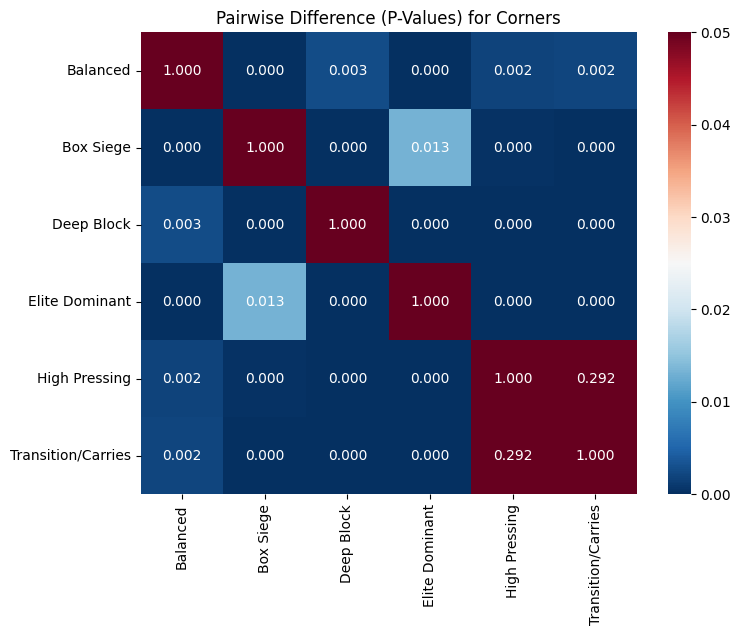

Interpretation: Cells with P < 0.05 (Red/Light) indicate statistically distinct groups.


ANALYSIS: Possession %
------------------------------------------------------------
ANOVA P-Value: 0.0000000000
-> Result: Significant difference exists among groups.



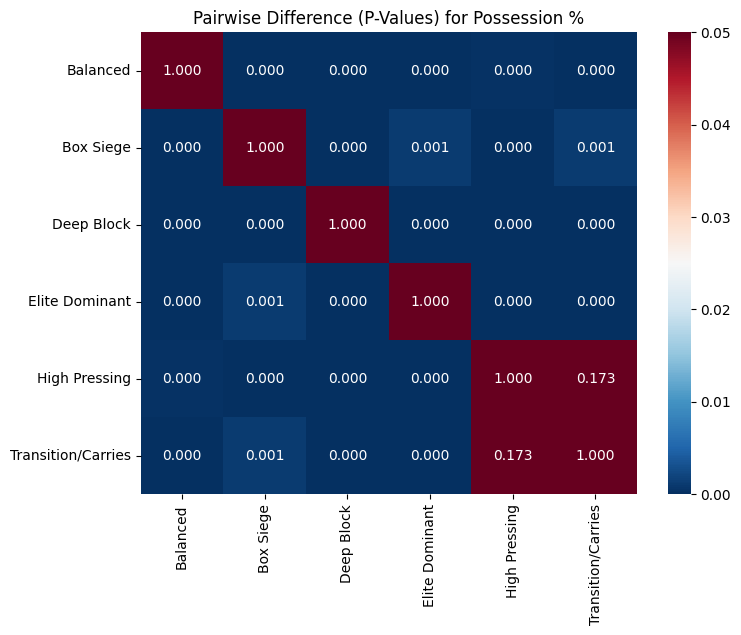

Interpretation: Cells with P < 0.05 (Red/Light) indicate statistically distinct groups.


ANALYSIS: Expected Goals
------------------------------------------------------------
ANOVA P-Value: 0.0000000000
-> Result: Significant difference exists among groups.



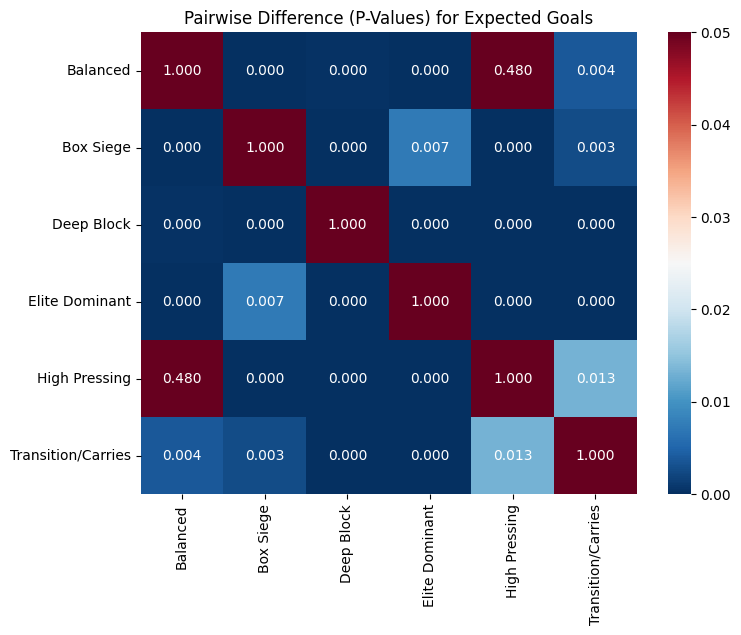

Interpretation: Cells with P < 0.05 (Red/Light) indicate statistically distinct groups.


ANALYSIS: High Pressing
------------------------------------------------------------
ANOVA P-Value: 0.0000000000
-> Result: Significant difference exists among groups.



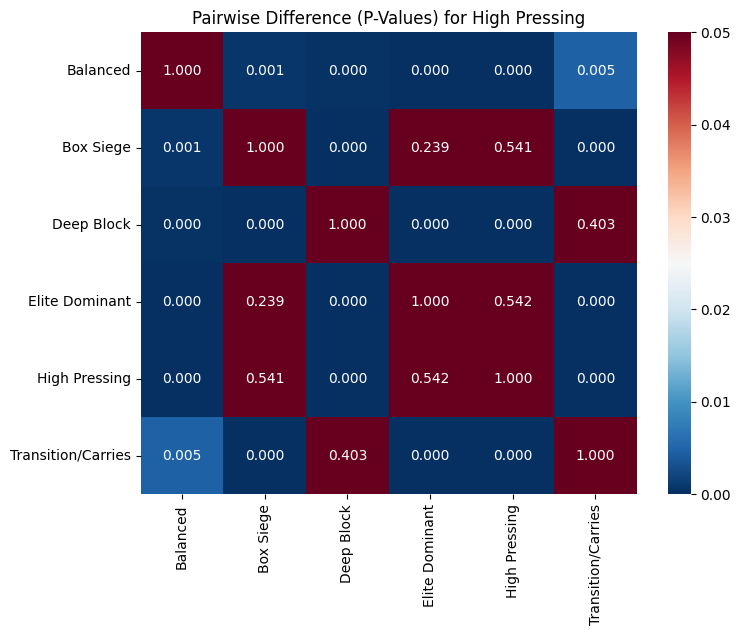

Interpretation: Cells with P < 0.05 (Red/Light) indicate statistically distinct groups.




/tmp/ipython-input-4201864128.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=home_profiles, x='Style', y=metric, ax=axes[i], palette='viridis')
/tmp/ipython-input-4201864128.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=home_profiles, x='Style', y=metric, ax=axes[i], palette='viridis')
/tmp/ipython-input-4201864128.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=home_profiles, x='Style', y=metric, ax=axes[i], palette='viridis')
/tmp/ipython-input-4201864128.py:84: FutureWarning: 

Passing `palette` without as

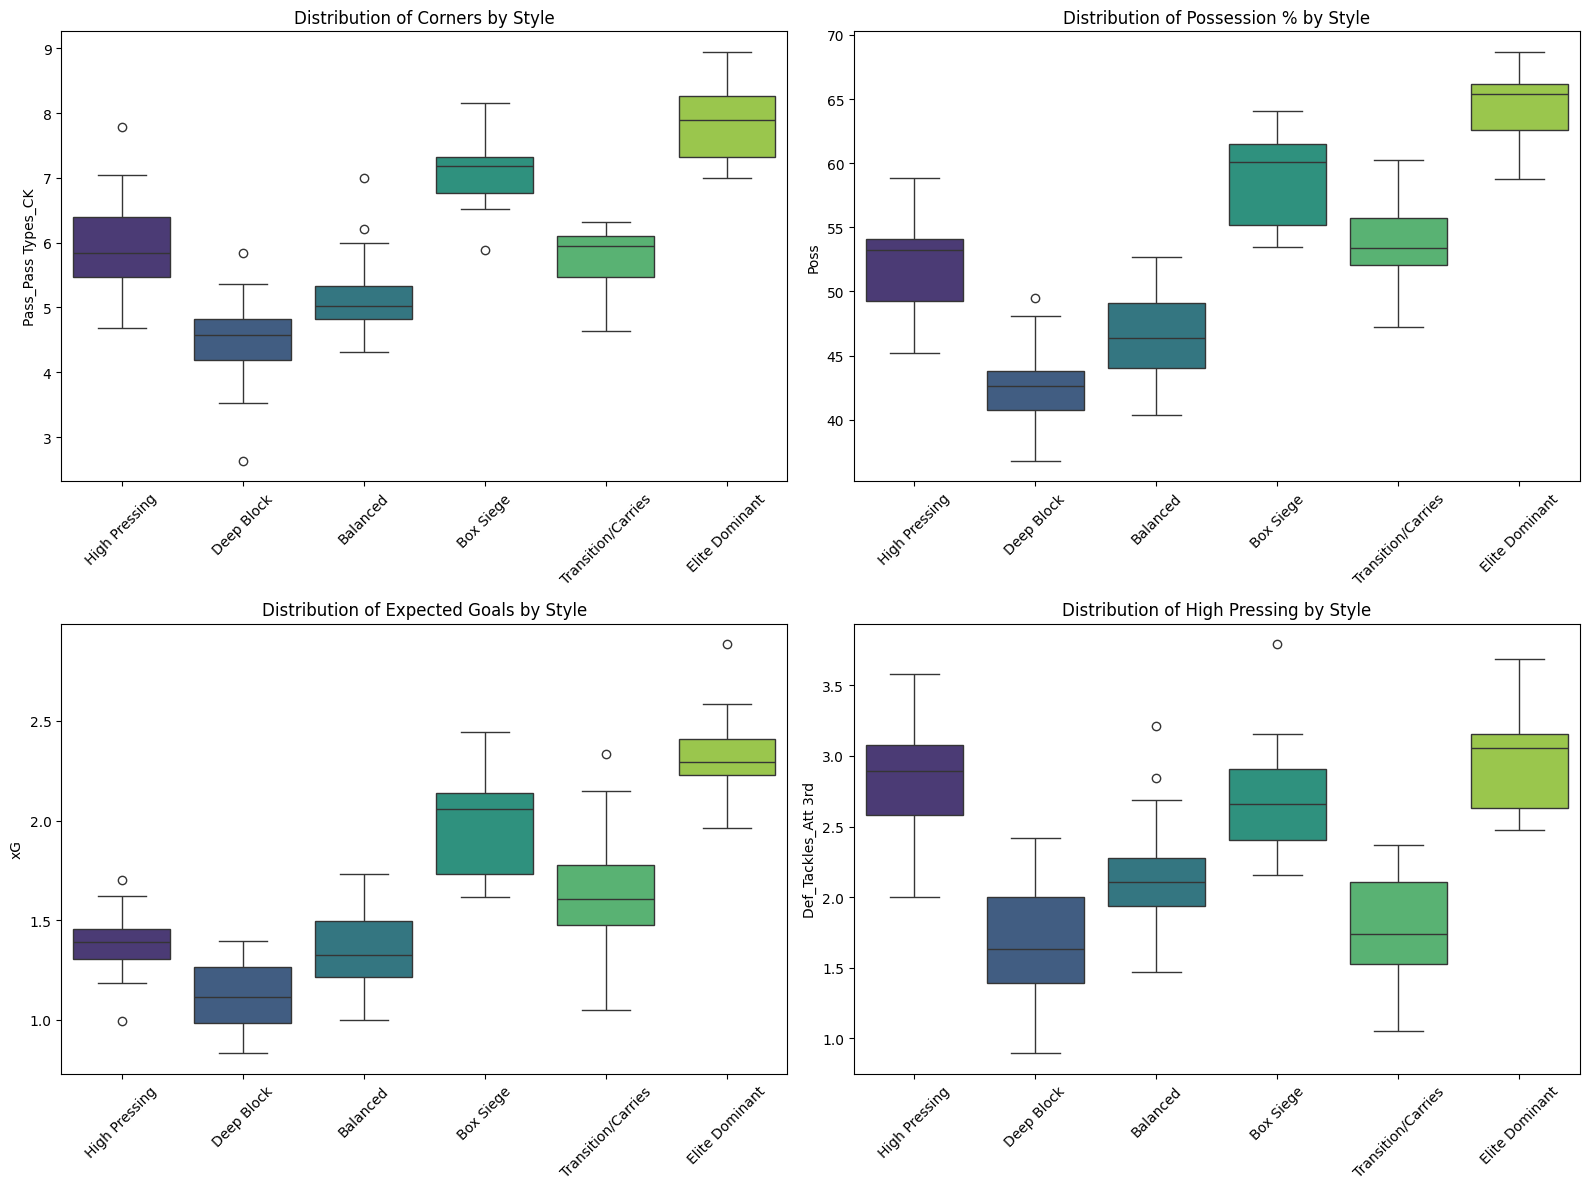

In [24]:
#HYPOTHESIS TEST

import pandas as pd
import scipy.stats as scipy_stats
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# PREPARE DATA
# Ensure we have the Style column mapped
# (Assuming home_profiles and home_labels are already defined from previous steps)
home_profiles['Style'] = home_profiles['cluster'].map(home_labels).fillna("Others")

# Metrics to analyze across all 6 clusters
metrics_to_test = {
    'Pass_Pass Types_CK': 'Corners',
    'Poss': 'Possession %',
    'xG': 'Expected Goals',
    'Def_Tackles_Att 3rd': 'High Pressing'
}

print("\n--- COMPREHENSIVE CLUSTER VALIDATION (ANOVA + PAIRWISE T-TESTS) ---\n")

# ITERATE THROUGH EACH METRIC
for metric, metric_name in metrics_to_test.items():
    print(f"ANALYSIS: {metric_name}")
    print("-" * 60)

    # Get data for each group
    groups = []
    group_names = []

    # Sort groups alphabetically to keep order consistent
    unique_styles = sorted(home_profiles['Style'].unique())

    for style in unique_styles:
        data = home_profiles[home_profiles['Style'] == style][metric]
        groups.append(data)
        group_names.append(style)

    # STEP A: ANOVA TEST (Global Check)
    f_stat, p_val_anova = scipy_stats.f_oneway(*groups)

    print(f"ANOVA P-Value: {p_val_anova:.10f}")

    if p_val_anova < 0.05:
        print("-> Result: Significant difference exists among groups.\n")

        # STEP B: PAIRWISE T-TESTS (The Manual Approach)
        # We will create a matrix to store p-values for every pair
        p_val_matrix = pd.DataFrame(index=group_names, columns=group_names)

        # Calculate P-Value for every pair
        for i in range(len(groups)):
            for j in range(len(groups)):
                if i != j:
                    stat, p = scipy_stats.ttest_ind(groups[i], groups[j], equal_var=False)
                    p_val_matrix.iloc[i, j] = p
                else:
                    p_val_matrix.iloc[i, j] = 1.0 # Comparison with self is not significant

        # Convert to float
        p_val_matrix = p_val_matrix.astype(float)

        # VISUALIZATION: P-Value Heatmap
        # Dark Blue means NO difference (High P-Value)
        # Red/White means HUGE difference (Low P-Value)
        plt.figure(figsize=(8, 6))
        sns.heatmap(p_val_matrix, annot=True, fmt=".3f", cmap="RdBu_r", vmin=0, vmax=0.05)
        plt.title(f"Pairwise Difference (P-Values) for {metric_name}")
        plt.show()

        print("Interpretation: Cells with P < 0.05 (Red/Light) indicate statistically distinct groups.")

    else:
        print("-> Result: No significant difference found among groups.")

    print("\n" + "="*60 + "\n")

# VISUALIZATION: BOXPLOTS FOR ALL CLUSTERS
# Show the distribution of each metric for each cluster side-by-side
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (metric, metric_name) in enumerate(metrics_to_test.items()):
    sns.boxplot(data=home_profiles, x='Style', y=metric, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Distribution of {metric_name} by Style")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()